# The Hydrogen atom

*Note: This is the third of a series of three jupyter notebooks. Generic explanations are given along with the code; however, for a more thorough explanation of the techniques used please visit the first notebook (linked next). The first and second notebooks can be found at this [GitHub repository](https://github.com/javier-rozalen/AJP-Article).*

Here we solve the hydrogen atom in 1D using the NQS method. The full 3D Hamiltonian in spherical coordinates $(r,\theta,\varphi)$ reads:

$$\hat{H}=-\frac{\hbar^2}{2\mu}\bigg\{ \frac{1}{r^2}\frac{\partial}{\partial r}\bigg(r^2\frac{\partial}{\partial r}\bigg)+\frac{1}{r^2}\bigg[\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\bigg(\sin\theta\frac{\partial}{\partial\theta}\bigg)+\frac{1}{\sin^2\theta}\frac{\partial^2}{\partial\phi^2}\bigg]\bigg\}-\frac{Ze^2}{r},$$

where $\mu$ is the reduced mass of the system, $Z$ is the atomic number ($Z=1$ for Hydrogen), $\hbar$ is the reduced Planck constant and $e$ is the electrical charge of the electron. Here, the standard "next step" is to employ the definition of angular momentum,

$$ L^2=-\hbar^2 \bigg[\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\bigg(\sin\theta\frac{\partial}{\partial\theta}\bigg)+\frac{1}{\sin^2\theta}\frac{\partial^2}{\partial\phi^2}\bigg],$$

and then seize the fact that $[H_r,L^2]=[H_r,L_z]=[L^2,L_z]=0$ to write our wave functions in a factorized manner: $\psi_{nlm}(r,\theta,\varphi)=R_{nl}(r)Y_{lm}(\theta,\varphi)$, where $Y_{lm}(\theta,\varphi)$ are the spherical harmonics. This is useful because the spherical harmonics are eigenstates of $L^2$ with eigenvalues $l(l+1)\hbar^2$, and this allows us to rewrite our Hamiltonian as follows:

$$\hat{H}=-\frac{\hbar^2}{2\mu}\frac{1}{r^2}\frac{\partial}{\partial r}\bigg(r^2\frac{\partial}{\partial r}\bigg)+\frac{l(l+1)\hbar^2}{2\mu r^2}-\frac{Ze^2}{r}.$$

This last result important because it tells us that we can write the Hamiltonian for a given $l$ as only depending on $r$, so at this point we are effectively dealing with a 1D problem. We now introduce the usual definition of the "reduced (radial) functions":

$$ R_{nl}(r)\equiv\frac{P_{nl}(r)}{r}. $$

Our Neural Quantum States are ansätze of the functions $P_{nl}(r)$. However, we employ the same notation as for the HO and the DW, and we note the NQS by $|\psi_{nl}\rangle$. It is also important to work in *atomic units*, defined in practice by the relations: $m_e=e=\hbar=1$, where $m_e$ is the mass of the electron. This, along with the approximation $\mu\approx m_e$ leads us to the final expression for the Hamiltonian (in atomic units):

$$\hat{H}=-\frac{1}{2}\frac{d^2}{dr^2}+\frac{l(l+1)}{2r^2}-\frac{Z}{r}.$$

## Imports
We start our code by importing the necessary modules.

In [1]:
# Imports
%matplotlib notebook
import torch, time
from sympy import *
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

## General parameters

We define the various parameters and hyperparameters. Here, we will construct our lattice as a uniform grid in the interval $[h, 20]$, where $h$ is the spacing between lattice points. This is because the Hamiltonian has poles at $r=0$, and starting at $h$ is a way of avoiding numerical instabilities associated to this fact. 

In [2]:
# Hardware (CPU or GPU)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 8  # Nodes in the hidden layer

# Physical parameters
Z = 1 # atomic number

# Network parameters.
seed = 2
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

# Training hyperparameters
epochs = 3000
lr = 1e-3  # Learning rate

# Mesh parameters
Nr = 1000                    # Mesh division
train_a = 0                     # Mesh lower limit
train_b = 25                        # Mesh upper limit
h = (train_b - train_a) / (Nr - 1)  # Mesh parameter "h"
wi = torch.empty(Nr, 1).fill_(h) # Integration weights. Trapezoids with zero boundaries
Q_train = torch.linspace(train_a+h, train_b, Nr, requires_grad=True, device=device)      

## Obtaining the benchmark functions

The hydrogen atom, although mathematically involved, can be solved analytically. The general form of the solutions is long, but since we are only concerned with the radial coordinate $r$, we will write the form of some functions $P_{nl}(r)$ for some values of $n, l$:

$$ P_{10}(r) = 2Z^{3/2}re^{-Zr}, $$

$$ P_{20}(r) = \frac{1}{\sqrt{2}}Z^{3/2}r\bigg(1-\frac{1}{2}Zr\bigg)e^{-Zr/2}, $$

$$ P_{21}(r) = \frac{1}{2\sqrt{6}}Z^{5/2}r^2e^{-Zr/2}. $$

Below is a simple Python implementation for these functions that we shall later use for benchmarking purposes.

<IPython.core.display.Javascript object>


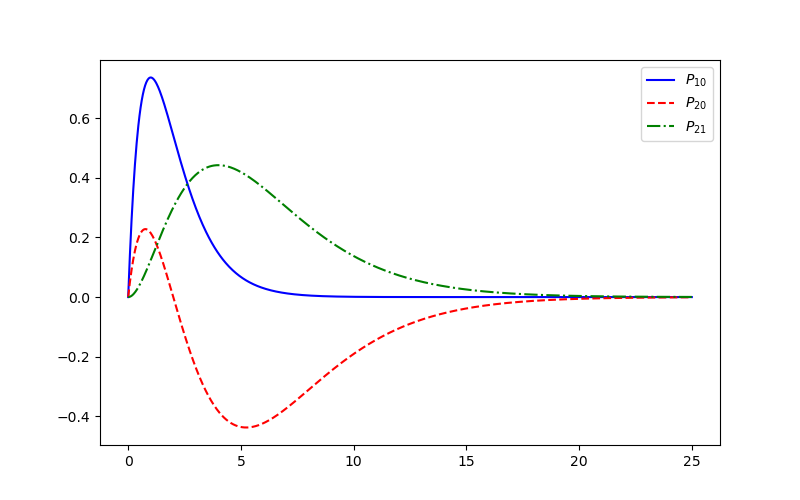

In [3]:
P_10 = lambda r : 2.*np.power(Z, 1.5)*r*np.exp(-Z*r)
P_20 = lambda r : (1/np.sqrt(2.))*np.power(Z, 1.5)*r*(1-0.5*Z*r)*np.exp(-Z*r/2.)
P_21 = lambda r : (1/(2*np.sqrt(6.)))*np.power(Z, 2.5)*np.power(r, 2)*np.exp(-Z*r/2.)
E0_th = -0.5
E1_th = -1./8.

r_grid = np.linspace(train_a, train_b, 1000)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(r_grid, P_10(r_grid), color='b', label='$P_{10}$')
ax.plot(r_grid, P_20(r_grid), color='r', linestyle='--', label='$P_{20}$')
ax.plot(r_grid, P_21(r_grid), color='g', linestyle='-.', label='$P_{21}$')
ax.legend()
fig.canvas.draw()
time.sleep(0.1)

At this point it is interesting to compute the error we are introducing by starting our grid at $h$ instead of $0$. We can compute this as the energy from $0$ to $h$ using the analytical solution, in which the energy has no poles.

In [4]:
# We define a new lattice [0, h]
NNrr = 100000000
hh = h/NNrr 
x_test = np.linspace(0., hh, 100000000)

# P_10
dP_10_dr = lambda r : 2*np.power(Z, 1.5)*np.exp(-Z*r)*(1-Z*r)
deltaE = lambda r : hh * (0.5*np.power(dP_10_dr(r), 2) - 4*np.power(Z, 3)*np.power(r, 2)*np.exp(-2*r)).sum()
print(f'E_10(0, h) = {deltaE(x_test)}')

# P_21
dP_21_dr = lambda r : (1/(4*np.sqrt(6)))*np.power(Z, 2.5)*r*np.exp(-Z*r/2.)*(4-Z*r)
deltaE = lambda r : hh * (0.5*np.power(dP_21_dr(r), 2) +np.power(Z, 5)/96*np.exp(-Z*r)*(4-Z*r)*(1-Z*r) ).sum()
print(f'E_21(0, h) = {deltaE(x_test)}')

E_10(0, h) = 0.05005005002499997
E_21(0, h) = 0.0010427093757491535


## The neural network

We now create the neural network. The architecture is the same as that used for the HO, and therefore so is the code implementation.

In [5]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B, W2):
        super(HarmonicNQS, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o
    
net = HarmonicNQS(W1, B, W2).to(device)

## The optimizer

We use RMSprop as our optimizer. We can define our RMSprop optimizer in a single line of code:

In [6]:
optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

## The loss function

The loss function is computed in much the same fashion as for the HO and the DW cases, this is,

$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_{nl,\theta}}\hat{H}\ket{\psi_{nl,\theta}}}{\bra{\psi_{nl,\theta}}\psi_{nl,\theta}\rangle}. $$

Because we are working in polar coordinates and given that the interaction is Coulomb-like, the integrals above 

$$ \bra{\psi_{nl,\theta}}\hat{H}\ket{\psi_{nl,\theta}} = \int_0^\infty \bigg\{\frac{1}{2}\bigg(\frac{d\psi_{nl,\theta}(r)}{dr}\bigg)^2+\psi_{nl,\theta}^2(r)\bigg[\frac{l(l+1)}{2r^2}-\frac{Z}{r}\bigg]\bigg\}dr $$

With the usual discretisation these are written: 
$$ \bra{\psi_{nl,\theta}}\hat{H}\ket{\psi_{nl,\theta}} \approx \sum_{i=1}^{N_r} w_i \bigg[\frac{1}{2}\bigg(\frac{d\psi_{nl,\theta}(r_i)}{dr}\bigg)^2+\psi_{nl,\theta}^2(r_i)\bigg(\frac{l(l+1)}{2r_i^2}-\frac{Z}{r_i}\bigg)\bigg], $$

$$\bra{\psi_{nl,\theta}}\psi_{nl,\theta}\rangle\approx \sum_{i=1}^{N_r} w_i \psi_{nl,\theta}^2(r_i)\equiv N.$$

At this point we take an additional step and include an *envelope* to the NQS when computing the loss. The envelope is a function that multiplies the NQS and its purpose is to impose boundary conditions. In our case we must require that $\psi_{nl}(0)=0$, and we can achieve this just as it would be done analytically:

$$ \psi_{nl}(r)r^{l+1} \longleftarrow \psi_{nl}(r) $$

The code implementation is, then:

In [7]:
def loss_fn(l):  
    X_det = X.clone().detach()
    psi = net(X)*X.pow(l+1)
    psi2 = (net(X_det)*X_det.pow(l+1)).pow(2)
    dpsi_dr, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)   
    N = torch.tensordot(psi2, wi)                 
    U = torch.tensordot(psi2 * ( l*(l+1)/(2*X_det.pow(2)) - Z/X_det ), wi) / N  
    K = (1/2) * torch.tensordot(dpsi_dr.pow(2), wi) / N

    return K + U, U, K, psi, psi / torch.sqrt(N)

## Plotting

We set the function that does the plots periodically. Please note that the syntax is slightly more intricate than strictly necessary; this is intended to improve the final visualization of the plots in a jupyter notebook environment.

In [8]:
def pic(i, l, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title('Normalized wavefunction')
    wf = psi_normalized.detach().numpy()
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    try: 
        ax1.set_ylim(lim_inf, lim_sup) 
    except: 
        pass
    #if np.max(wf) < 0: wf = -wf
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(r_grid)
        ax1.lines[1].set_ydata(target)
        ax1.lines[2].set_xdata(r_grid)
        ax1.lines[2].set_ydata(np.power(r_grid, l+1))
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(r_grid, target, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.plot(r_grid, np.power(r_grid, l+1), linestyle='--', color='g', label='Envelope')
        ax1.legend()
    
    # Wave function
    ax2.set_title('NQS wavefunction')
    wf = psi.detach().numpy()
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    try: 
        ax2.set_ylim(lim_inf, lim_sup)
    except:
        pass
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.full(i+1, E0_th if l == 0 else E1_th)][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.full(i+1, E0_th if l == 0 else E1_th) , linestyle='--', label='$E_0$', color='b')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: $\ket{\psi_{10}}, \ket{\psi_{21}}$

The training is carried out in the exact same manner as for the HO and the DW, just by minimizing the loss function as defined in Section [The loss function](#The-loss-function) of this notebook. This loss function allows us to compute states with different angular momentum number $l$. Here we compute both $\ket{\psi_{10}}$ and $\ket{\psi_{21}}$.

<IPython.core.display.Javascript object>


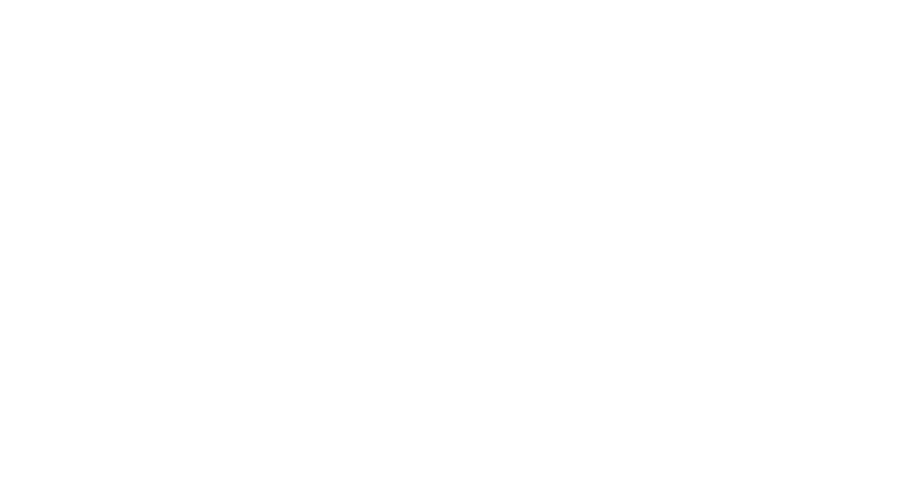

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 606.36it/s]


<IPython.core.display.Javascript object>


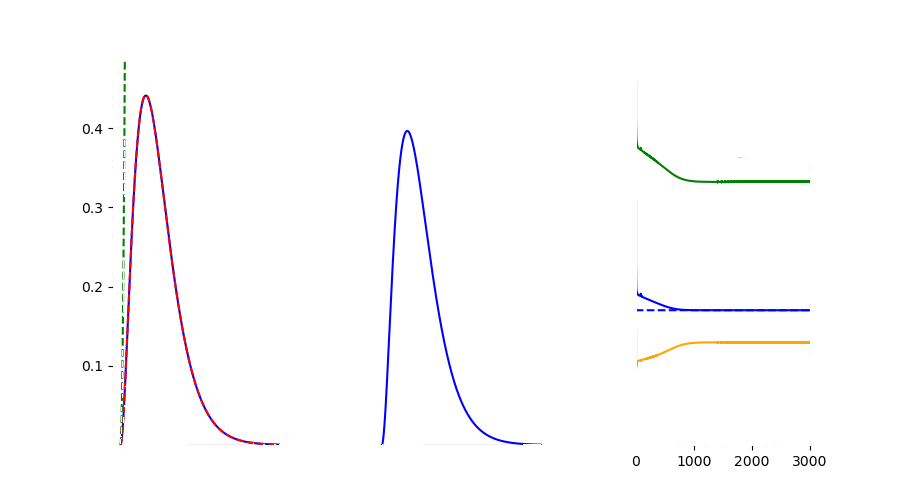

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 573.33it/s]


In [9]:
X = Q_train.clone().unsqueeze(1)
r_grid = Q_train.clone().detach().numpy()
r_grid = np.linspace(train_a, train_b, 10000)

# Traninig for l=0,1
for l in [0, 1]:
    # Plotting
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
    fig.suptitle(f'Training for l={l}', fontsize=18)
    ax1, ax2, ax3 = ax[0], ax[1], ax[2]
    plt.subplots_adjust(wspace=0.5)

    # Overlap
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$\psi(x)$")

    # Wave function
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$\psi(x)$")

    # Loss
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Cost")
    if l == 0: ax3.set_ylim(-0.6, -0.2)
    if l == 1: ax3.set_ylim(-0.3, 0.2)

    loss_accum = []
    U_accum = []
    K_accum = []
    
    if l == 0:
        target = P_10(r_grid)
    elif l == 1:
        target = P_21(r_grid)

    # Training loop
    for i in tqdm(range(epochs), desc="Training the NQS..."):
        loss_10, U, K, psi, psi_normalized = loss_fn(l)    # Energy and \psi calculation
        #print(psi)

        optimizer.zero_grad() # initialize gradients to zero at each epoch
        loss_10.backward()       # computation of the gradients
        optimizer.step()      # update of the parameters

        loss_accum.append(loss_10.item())
        U_accum.append(U.item())
        K_accum.append(K.item())

        if (i == epochs - 1) or (i % 500 == 0): # We plot periodically
            pic(i, l, Q_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
            time.sleep(0.01)
        if l == 0:
            E_10, psi_10 = loss_accum[-1], psi.clone().detach()
        elif l == 1:
            E_21, psi_21 = loss_accum[-1], psi.clone().detach()

*Note: When running the above cell more than once, please take into account that the network is already trained from the first run. To restart the training from scratch, first re-run the code cells of sections [General parameters](#General-parameters), [The neural network](#The-neural-network) and [The optimizer](#The-optimizer).*

## Training the network: first excited state, $\ket{\psi_{20}}$

We now go for the first excited state. The process is almost identical to that of finding the ground-state wave function, with the fundamental difference that now the Rayleigh-Ritz theorem demands that

$$ \langle\psi_{10,\theta}|\psi_{20,\theta'}\rangle = 0, $$

where $\psi_{10,\theta}, \psi_{20,\theta'}$ are the ansatz wave functions of the ground and first excited state, respectively. An obvious way to impose this condition is to add it to the loss function via a Lagrange multiplier:

$$ \mathcal{L'} = \frac{\bra{\psi_{20,\theta'}}\hat{H}\ket{\psi_{20,\theta'}}}{\langle\psi_{20,\theta'}|\psi_{20,\theta'}\rangle} + \lambda\frac{\langle\psi_{\theta,0}|\psi_{20,\theta'}\rangle^2}{\langle\psi_{20,\theta'}|\psi_{20,\theta'}\rangle\langle\psi_{10,\theta}|\psi_{10,\theta}\rangle}, $$

where $\lambda$ is the Lagrange multiplier. In numerical processes it is important to balance the magnitudes of the different terms appearing in the loss at every epoch. In our case, we can do this by setting $\lambda>E_1-E_0$, where $E_1$ is the first term of the loss and $E_0$ is the precomputed ground-state energy. 

In [10]:
def loss_fn_prime(l):  
    X_det = X.clone().detach()
    # Energy term
    psi = net1(X)*X.pow(l+1)
    psi2 = (net1(X_det)*X_det.pow(l+1)).pow(2)
    dpsi_dr, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)   
    N = torch.tensordot(psi2, wi)                 
    U = torch.tensordot(psi2 * ( l*(l+1)/(2*X_det.pow(2)) - Z/X_det ), wi) / N  
    K = (1/2) * torch.tensordot(dpsi_dr.pow(2), wi) / N
    E = K + U
    
    # Overlap term
    num = (torch.tensordot(psi*psi_10, wi)).pow(2)
    den = (torch.tensordot(psi2, wi)) * (torch.tensordot(psi_10.pow(2), wi))
    O = lambda_ * (num / den)
    
    # Total loss
    L = E + O
    
    return L, U, K, psi, psi / torch.sqrt(N) 

Now we define a new neural network, which has the same architecture as the one used for the ground state. We can do this by creating a new instance of our [previous NQS](#The-neural-network). We also reset the optimizer parameters by redefining it. 

In [11]:
# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 20  # Nodes in the hidden layer

l = 0

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients
lr = 5e-3
lambda_ = 10.

net1 = HarmonicNQS(W1, B, W2).to(device)
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=lr)
epochs = 3000

We define a new plotting function,

In [12]:
def pic(i, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title("Epoch {}".format(i+1))
    wf = psi_normalized.detach().numpy()
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    ax1.set_ylim(lim_inf, lim_sup)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(r_grid)
        ax1.lines[1].set_ydata(target)
        ax1.lines[2].set_xdata(r_grid)
        ax1.lines[2].set_ydata(np.power(r_grid, l+1))
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(r_grid, target, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.plot(r_grid, np.power(r_grid, l+1), color='g', linestyle='-.', label='Envelope')
        ax1.plot()
        ax1.legend()
    
    # Wave function
    ax2.set_title("Epoch {}".format(i+1))
    wf = psi.detach().numpy()
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    ax2.set_ylim(lim_inf, lim_sup)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    ax3.set_ylim(-0.2, 0.)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)*E1_th][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)*E1_th, linestyle='--', label='$E_1$', color='b')
        ax3.legend()
        
    fig.canvas.draw()

Now we are ready to train our ansatz $\psi_{20,\theta'}=\langle r | \psi_{20,\theta'}\rangle$.

<IPython.core.display.Javascript object>


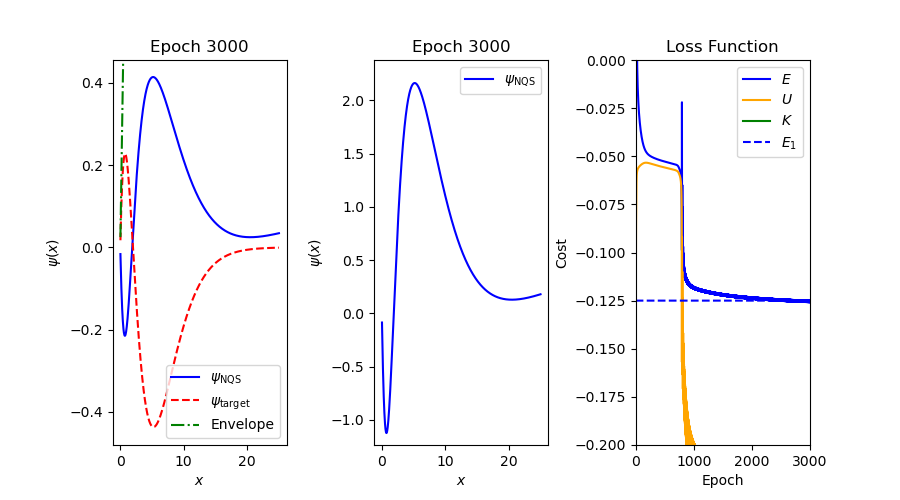

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 498.82it/s]


In [13]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)
r_grid = Q_train.clone().detach().numpy()
target = P_20(r_grid)

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss1, U, K, psi, psi_normalized = loss_fn_prime(l)    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss1.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss1.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 1000 == 0): # We plot periodically
        pic(i, Q_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.1)
        
E1, psi1 = loss_accum[-1], psi

## Extra: Computation Graph

Using the Python library found at this [GitHub repository](https://github.com/szagoruyko/pytorchviz) we construct the computation graph for the ground state $\psi_{10}(r)$.

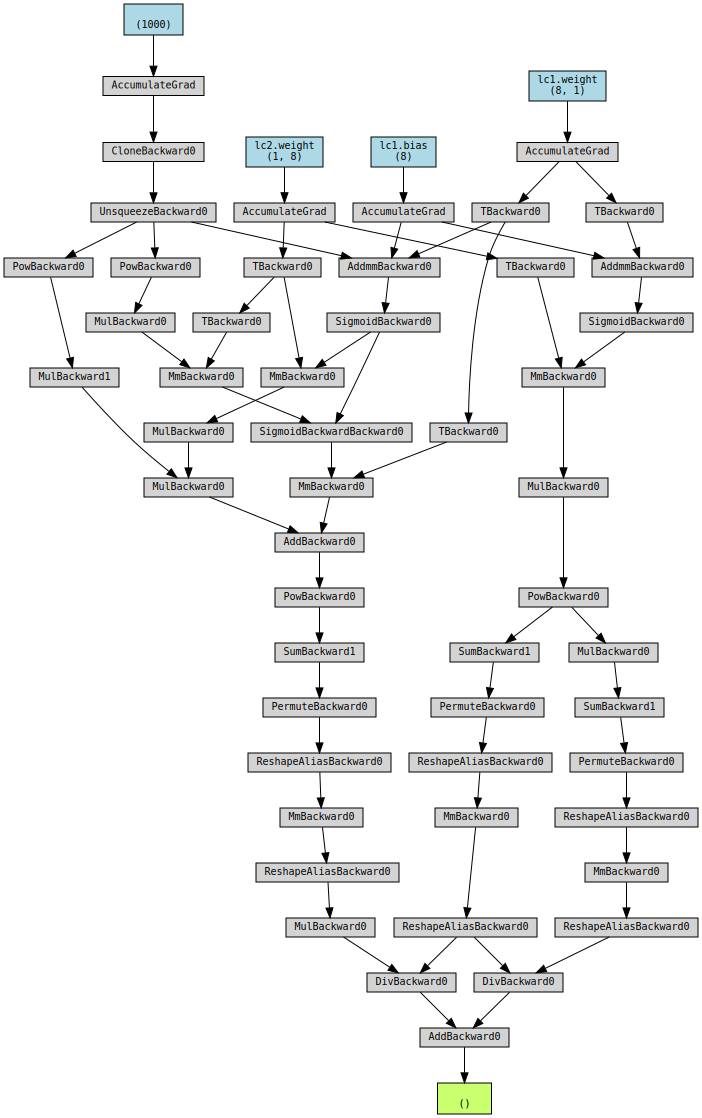

In [14]:
# Imports
from torchviz import make_dot 

make_dot(loss_10, params=dict(list(net.named_parameters())))